In [1]:
from SUGAR.inference import *
from tqdm import tqdm
import argparse
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# A toy example to reproduce the results of the paper on a local computer
# =============================================================================

"""
This specifies the arguments for the key parameters of the algorithm.

Parameters
----------
seed: random seed 
d: the dimension of the DAG network
K: the number of observations in the batched standard error estimators
N: the number of the subjects of the data
T: the length of the time sequence
c: paramether to control edge strength
M: the number of pseudo samples
B: the number of transformation functions
delta: paramether to control edge strength
prob: density of the DAG network
h_size: the number of hidden units for the neural network in surpervised ML part
n_iter: the number of iterations to train the neural network of GAN
v_dims: the dimension of the input noise for the generative model of GAN
h_dims: the number of hidden units for the neural network of GAN
max_iter: the maximum number of iterations for the DAG structure learning algorithm
graph_type: the type of the graph model
"""

parser = argparse.ArgumentParser(description='sugar')
parser.add_argument('-seed', '--seed', type=int, default=8)
parser.add_argument('-d', '--d', type=int, default=50)
parser.add_argument('-K', '--K', type=int, default=20)
parser.add_argument('-N', '--N', type=int, default=20)
parser.add_argument('-T', '--T', type=int, default=100)
parser.add_argument('-c', '--c', type=float, default=2)
parser.add_argument('-M', '--M', type=int, default=100)
parser.add_argument('-B', '--B', type=int, default=1000)
parser.add_argument('-delta', '--delta', type=float, default=1)
parser.add_argument('-prob', '--prob', type=float, default=0.1)
parser.add_argument('-h_size', '--h_size', type=int, default=100)
parser.add_argument('-n_iter', '--n_iter', type=int, default=300)
parser.add_argument('-v_dims', '--v_dims', type=int, default=5)
parser.add_argument('-h_dims', '--h_dims', type=int, default=2000)
parser.add_argument('-max_iter', '--max_iter', type=int, default=20)
parser.add_argument('-graph_type', '--graph_type', type=str, default="nonlinear")
args = parser.parse_args(args=[])

def run_sim(d,graph_type,N,T,delta):
    """
    This produces the results for the simulation in section 5 of the paper. Different choices of key parameters are considered for the sensitivity analysis.
    
    Input
    ----------
    d: the dimension of the DAG network
    graph_type: the type of the graph model
    N: the number of the subjects of the data
    T: the length of the time sequence
    delta: paramether to control edge strength
    
    Output
    ----------
    There is no output but the function saves the results into NumPy file.
    """
    args.d = d
    args.graph_type = graph_type
    args.N = N
    args.T = T
    args.delta = delta
    
    # consider different densities under different dimensions
    if args.d == 50:
        args.prob = 0.1
    elif args.d == 100:
        args.prob = 0.04
    elif args.d == 150:
        args.prob = 0.02       
    
    # initialize the weights of the network, which will be further updated later in nonlinear model because of the interactions
    np.random.seed(8)
    W0 = generate_W(d=args.d, prob=args.prob)
    
    # # estimate the DAG structure 
    # b_ls = struct_learn(W0,args.graph_type,args)
    
    # To save the computational time for this toy demonstration, instead of estimating the DAG structure 
    # which could take very long time on a personal laptop, we directly load the previously saved graph after estimation
    b_ls = np.load("data/graph_d"+str(d)+"_N"+str(N)+"_T"+str(T)+"_delta"+str(delta)+".npy",allow_pickle=True)

    
    # calculate the true DAG graph and specify the number of hidden units for neural network
    if args.graph_type=="nonlinear":
        W = cal_true_graph(args,W0)
        args.h_dims = 2000
    elif args.graph_type=="linear":
        W = W0
        args.h_dims = 1000
    
    # randomly select 100 edges for testing the null or alterative hypothesis seperately
    np.random.seed(8)
    arr_index = np.arange(args.d**2).reshape([args.d,args.d])
    edge_null = arr_index[W==0]
    edge_alter = arr_index[W!=0]
    edge_null_select = np.random.choice(edge_null,100,replace=False)
    edge_alter_select = np.random.choice(edge_alter,100,replace=False)
    edge_null_pair = [index_to_graph(item,args.d) for item in edge_null_select]
    edge_alter_pair = [index_to_graph(item,args.d) for item in edge_alter_select]
    
    # we use the calculation of the p value for the edges under the null hypothesis as an example
    result_all = []
    label = 1
    for edge in edge_null_pair:
        print("(ID "+str(label)+") Testing for the edge: ",str(edge[0]),",",str(edge[1]),"\n")
        j = edge[0] 
        k = edge[1] 
        result_iter=[]
        for seed in tqdm(range(200)):
            # repeat the simulations for 200 times under different seeds
            result=cal_pvalue(seed,j,k,W0,b_ls,args)
            result_iter.append(result)  
            # print("p value every random: ",result_iter)
        result_all.append(result_iter)
        path = "data/"+args.graph_type+"_"+str(args.d)+"_null_N_"+str(args.N)+"_T_"+str(args.T)+"_delta_"+str(args.delta)
        np.save(path,result_all)
        label += 1

In [ ]:
# as a specific example here, we consider d=50, model type is nonlinear, N=20, T=100, delta=0.5, 
# and calculate the pvalues for each edge across 200 repetitions under the null hypothesis.
import time 
t1 = time.time()
run_sim(50,"nonlinear",20,100,0.5)
t2 = time.time()
print(t2-t1)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# =============================================================================
# The resulting plot of the toy example to run on a laptop when delta = 0.5
# =============================================================================


def generate_plot_null(ax1,d,N,T,delta,string):
    """
    This generates the plot for the simulation results under the null.
    
    Input
    ----------
    d: the dimension of the DAG network
    N: the number of the subjects of the data
    T: the length of the time sequence
    delta: paramether to control edge strength
    
    Output
    ----------
    There is no output but corresponded plots are generated.
    """
    
    pvalue_sugar_ls_null = []
    pvalue_drt_ls_null = []     
    path = "data/nonlinear_"+str(d)+"_null_N_"+str(N)+"_T_"+str(T)+"_delta_"+str(delta)+".npy"
    pvalue_all1=np.load(path,allow_pickle=True)
    for i in range(len(pvalue_all1)):
        pvalue_sugar_null = np.mean(np.array([item[0] for item in pvalue_all1[i]])<0.05)
        pvalue_drt_null = np.mean(np.array([item[1] for item in pvalue_all1[i]])<0.05)
        pvalue_sugar_ls_null.append(pvalue_sugar_null)
        pvalue_drt_ls_null.append(pvalue_drt_null)
    pvalue_sugar_ls_null = np.array(pvalue_sugar_ls_null)
    pvalue_drt_ls_null = np.array(pvalue_drt_ls_null)
   

    path = "data/LRT_nonlinear_"+str(d)+"_null_N_"+str(N)+"_T_"+str(T)+"_delta_"+str(delta)+".npy"
    pvalue_all2=np.load(path,allow_pickle=True)
    pvalue_lrt_null = np.mean(pvalue_all2<0.05,1)

    bp1 = ax1.boxplot(pvalue_sugar_ls_null,positions=[1],widths=0.6)
    bp2 = ax1.boxplot(pvalue_drt_ls_null,positions=[2],widths=0.6)
    bp3 = ax1.boxplot(pvalue_lrt_null,positions=[3],widths=0.6)

    ax1.axhline(y=0.05, color='red', linestyle='--')
    ax1.set_xticks(np.arange(1, 4, 1));
    ax1.set_xticklabels(["SUGAR","DRT","LRT"],fontsize= 12)

    ax1.set_title("d = "+str(d)+", N= "+str(N)+", T = "+str(T) + r", $\delta$ = " + str(delta), fontsize=12) 
    
    ax1.set_title(string, fontsize=16)
    
def generate_plot_alter(ax1,d,N,T,delta,string):
    """
    This generates the plot for the simulation results under the alternative.
    
    Input
    ----------
    d: the dimension of the DAG network
    N: the number of the subjects of the data
    T: the length of the time sequence
    delta: paramether to control edge strength
    
    Output
    ----------
    There is no output but corresponded plots are generated.
    """
    
    pvalue_sugar_ls_alter = []
    pvalue_drt_ls_alter = []     
    path = "data/nonlinear_"+str(d)+"_alter_N_"+str(N)+"_T_"+str(T)+"_delta_"+str(delta)+".npy"
    pvalue_all1=np.load(path,allow_pickle=True)
    for i in range(len(pvalue_all1)):
        pvalue_sugar_alter = np.mean(np.array([item[0] for item in pvalue_all1[i]])<0.05)
        pvalue_drt_alter = np.mean(np.array([item[1] for item in pvalue_all1[i]])<0.05)
        pvalue_sugar_ls_alter.append(pvalue_sugar_alter)
        pvalue_drt_ls_alter.append(pvalue_drt_alter)
    pvalue_sugar_ls_alter = np.array(pvalue_sugar_ls_alter)
    pvalue_drt_ls_alter = np.array(pvalue_drt_ls_alter)
    
    bp1 = ax1.boxplot(pvalue_sugar_ls_alter,positions=[1],widths=0.6)
    bp2 = ax1.boxplot(pvalue_drt_ls_alter,positions=[2],widths=0.6)
    
    ax1.axhline(y=0.05, color='red', linestyle='--')
    ax1.set_xticks(np.arange(1, 3, 1));
    ax1.set_xticklabels(["SUGAR","DRT"],fontsize= 12)

    ax1.set_title(string, fontsize=16)
    
def generate_plot_diff(ax1,d,N,T,delta,string):
    """
    This generates the power difference plot for the simulation results under the alternative.
    
    Input
    ----------
    d: the dimension of the DAG network
    N: the number of the subjects of the data
    T: the length of the time sequence
    delta: paramether to control edge strength
    
    Output
    ----------
    There is no output but corresponded plots are generated.
    """
    
    pvalue_sugar_ls_alter = []
    pvalue_drt_ls_alter = []     
    path = "data/nonlinear_"+str(d)+"_alter_N_"+str(N)+"_T_"+str(T)+"_delta_"+str(delta)+".npy"
    pvalue_all1=np.load(path,allow_pickle=True)
    for i in range(len(pvalue_all1)):
        pvalue_sugar_alter = np.mean(np.array([item[0] for item in pvalue_all1[i]])<0.05)
        pvalue_drt_alter = np.mean(np.array([item[1] for item in pvalue_all1[i]])<0.05)
        pvalue_sugar_ls_alter.append(pvalue_sugar_alter)
        pvalue_drt_ls_alter.append(pvalue_drt_alter)
    pvalue_sugar_ls_alter = np.array(pvalue_sugar_ls_alter)
    pvalue_drt_ls_alter = np.array(pvalue_drt_ls_alter)
    
    bp1 = ax1.boxplot(pvalue_sugar_ls_alter - pvalue_drt_ls_alter,widths=0.6)
    
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_xticks(np.arange(1, 2, 1));
    ax1.set_xticklabels(["Difference between SUGAR and DRT"],fontsize= 12)
    
    ax1.set_title(string, fontsize=16)

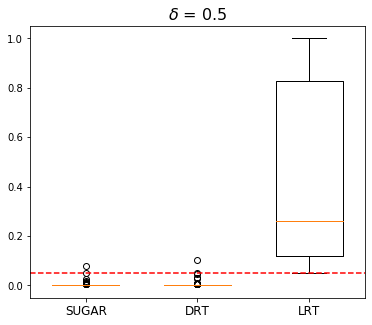

In [31]:
f, ax = plt.subplots(1, 1, figsize=(6,5))
generate_plot_null(ax,50,20,100,0.5,"$\delta$ = 0.5")